In [1]:
import json
import os
from collections import defaultdict

output_dir = "/data/apperception-data/exit-output/run"

performance_dir = os.path.join(output_dir, "performance--q2-de_1")
noop_performance_dir = os.path.join(output_dir, "performance--q2-noopt_1")
detection_dir = os.path.join(output_dir, "detection--q2-de_1")
sort_dir = os.path.join(output_dir, "sort--q2-de_1")
noop_sort_dir = os.path.join(output_dir, "sort--q2-noopt_1")


def filter_cars(detections):
    return [d for d in detections if d[-1] == 2.0]


def extract_pairs(sort_results):
    pairs = []
    for detection in sort_results.values():
        if detection:  # make sure detection is not empty
            pairs.append((detection['object_id'], tuple(detection['detection_id'])))
    return pairs


def calculate_matches(current_sort_results, next_sort_results, current_noop_results, next_noop_results):
    # Convert the results into lists of (object_id, detection_id) tuples
    current_sort_pairs = extract_pairs(current_sort_results)
    next_sort_pairs = extract_pairs(next_sort_results)
    current_noop_pairs = extract_pairs(current_noop_results)
    next_noop_pairs = extract_pairs(next_noop_results)

    # Create dictionaries to map detection_ids to object_ids for current and next frames
    current_sort_dict = {det_id: obj_id for obj_id, det_id in current_sort_pairs}
    next_sort_dict = {det_id: obj_id for obj_id, det_id in next_sort_pairs}
    current_noop_dict = {det_id: obj_id for obj_id, det_id in current_noop_pairs}
    next_noop_dict = {det_id: obj_id for obj_id, det_id in next_noop_pairs}
    TP = FP = FN = 0  # Initialize counts

    # Calculate matches
    for current_det_id, current_obj_id in current_sort_dict.items():
        # Check if current detection id is in both current frame sort and noop
        if current_det_id in current_noop_dict:
            # Check if the next detection id for current detection id is the same in sort and noop
            for next_det_id, next_obj_id in next_sort_dict.items():
                if next_obj_id == current_obj_id:
                    if next_det_id in next_noop_dict:
                        if next_noop_dict[next_det_id] == current_noop_dict[current_det_id]:
                            TP += 1  # True positive: detection id is correctly tracked from current to next
                        else:
                            FN += 1
        else:
            FP += 1  # False positive: detection id is tracked in sort but not in noop

    # As before, TN is not calculated as it's not defined in this context
    return TP, FP, FN


performance_files = sorted(os.listdir(performance_dir))
noop_performance_files = sorted(os.listdir(noop_performance_dir))
sort_files = sorted(os.listdir(sort_dir))
noop_sort_files = sorted(os.listdir(noop_sort_dir))
# detection_files = sorted(os.listdir(detection_dir))

skip_map = defaultdict(lambda: {
    'count': 0,
    'f1': [],
    '_f1': [],
    'tp': 0,
    'fp': 0,
    'fn': 0,
    'de_strongsort_time': [],
    'total_strongsort_time': []
})


def calculate_f1(TP, FP, FN):
    # calculate f1 score for the skip_map
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1


for i in range(len(performance_files)):
    with open(os.path.join(performance_dir, performance_files[i])) as f:
        performance = json.load(f)
    with open(os.path.join(noop_performance_dir, noop_performance_files[i])) as f:
        noop_performance = json.load(f)
    with open(os.path.join(sort_dir, sort_files[i])) as f:
        sort_result = json.load(f)
    with open(os.path.join(noop_sort_dir, noop_sort_files[i])) as f:
        noop_sort_result = json.load(f)
    # with open(os.path.join(detection_dir, detection_files[i])) as f:
    #     all_detections = json.load(f)

    detection_estimation_benchmark = performance[5]["benchmark"]
    assert performance[6]['stage'] == 'Tracking2D.StrongSORT'
    ss_de_benchmark = [p for p in performance if 'addition' in p and p['addition'] and p['stage'] == 'Tracking2D.StrongSORT'][0]["benchmark"]
    strong_sort_benchmark = noop_performance[5]["benchmark"]
    # import code; code.interact(local=dict(globals(), **locals()))
    skip_track = detection_estimation_benchmark.get("skip_track", [])

    for track in skip_track:
        current_f, next_f, process_time = track
        skip_map[next_f-current_f-1]["count"] += 1
        # print('frame_process_time' in ss_de_benchmark)
        # print(ss_de_benchmark)
        skip_map[next_f-current_f-1]["de_strongsort_time"].append(process_time + sum(ss_de_benchmark["frame_process_time"][current_f:next_f]))
        # Assuming sort_result and noop_sort_result are your pipeline results
        TP, FP, FN = calculate_matches(sort_result[current_f],
                                       sort_result[next_f],
                                       noop_sort_result[current_f],
                                       noop_sort_result[next_f])
        skip_map[next_f-current_f-1]["tp"] += TP
        skip_map[next_f-current_f-1]["fp"] += FP
        skip_map[next_f-current_f-1]["fn"] += FN
        skip_map[next_f-current_f-1]["f1"].append(calculate_f1(TP, FP, FN))

        overskip_counted = False
        # for f in range(current_f, next_f):
        skip_map[next_f-current_f-1]["total_strongsort_time"].append(sum(strong_sort_benchmark["frame_process_time"][current_f:next_f]))

    # for k in skip_map.values():
    #     k['de_strongsort_time'] /= k['count']
    #     k['total_strongsort_time'] /= k['count']

skip_map = dict(skip_map)
for skip in skip_map:
    skip_map[skip]["_f1"] = calculate_f1(skip_map[skip]["tp"], skip_map[skip]["fp"], skip_map[skip]["fn"])

In [2]:
total_count = 0
total_frame_skipped = 0
for skipping_distance in skip_map:
    total_frame_skipped += skipping_distance * skip_map[skipping_distance]["count"]
    total_count += skip_map[skipping_distance]["count"]
print(total_frame_skipped)
print(total_count)
print(total_frame_skipped/240)

7331
33756
30.545833333333334


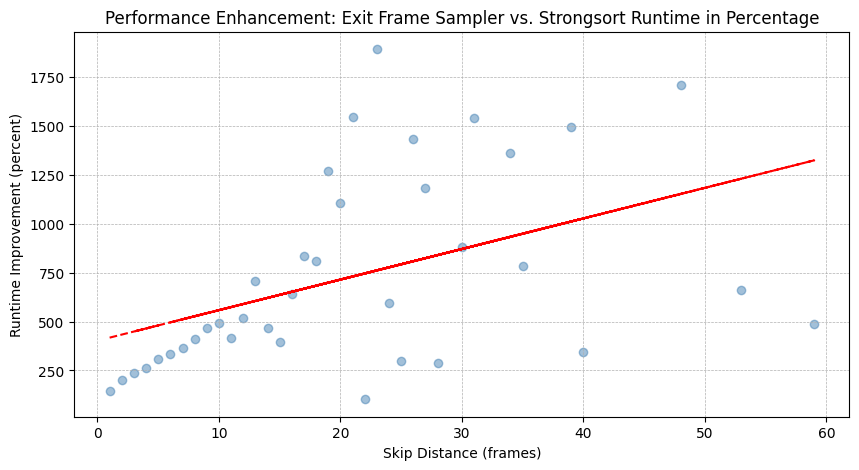

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming skip_map is the dictionary you have after running the above code
# Prepare the data for plotting
x_values = []
y_values = []
for x, s in skip_map.items():
    if x == 0:
        continue
    data_points = []
    for t, d in zip(s['total_strongsort_time'], s['de_strongsort_time']):
        data_points.append(t * 100 / d)
    x_values.append(x)
    y_values.append(np.average(data_points))
# x_values = sorted(skip_map.keys())[1:]  # Sorting the keys to ensure the plot is ordered
# y_values = [skip_map[k]['total_strongsort_time'] - skip_map[k]['de_strongsort_time'] for k in x_values]
coef = np.polyfit(x_values, y_values, deg=1)
poly1d_fn = np.poly1d(coef)

# Plotting the data
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.scatter(x_values, y_values, color='steelblue', alpha=0.5)
plt.plot(x_values, poly1d_fn(x_values), '--r')  # Create a bar plot

# Add titles and labels
plt.title('Performance Enhancement: Exit Frame Sampler vs. Strongsort Runtime in Percentage')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('Runtime Improvement (percent)')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

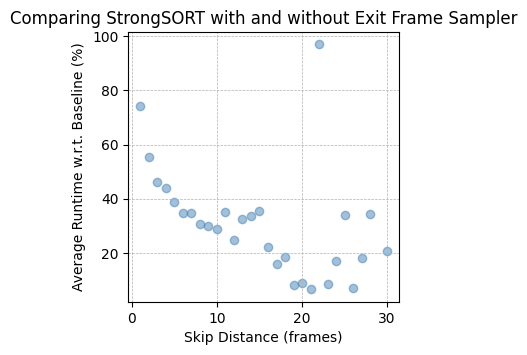

In [20]:
# Assuming skip_map is the dictionary you have after running the above code
# Prepare the data for plotting
x_values = []
y_values = []
for x, s in skip_map.items():
    if x == 0 or x > 30:
        continue
    data_points = []
    for t, d in zip(s['total_strongsort_time'], s['de_strongsort_time']):
        data_points.append(d / t)
    x_values.append(x)
    y_values.append(100 * np.average(data_points))

# Plotting the data
plt.figure(figsize=(3.5, 3.5))  # You can adjust the figure size as needed
plt.scatter(x_values, y_values, color='steelblue', alpha=0.5)

# Add titles and labels
plt.title('Comparing StrongSORT with and without Exit Frame Sampler')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('Average Runtime w.r.t. Baseline (%)')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

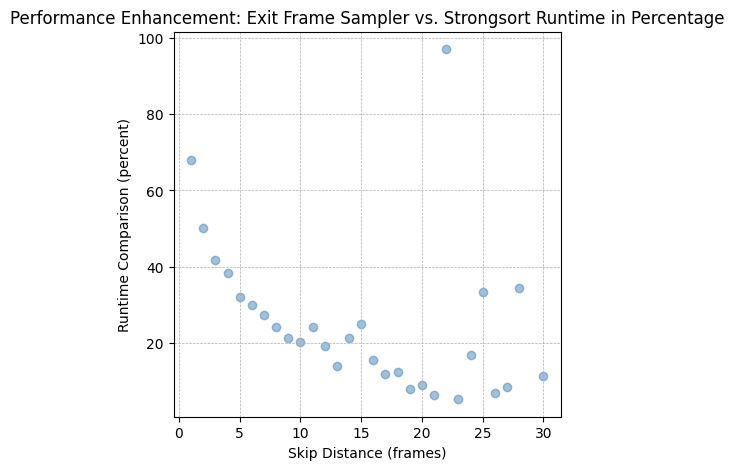

In [10]:
# Assuming skip_map is the dictionary you have after running the above code
# Prepare the data for plotting
x_values = []
y_values = []
for x, s in skip_map.items():
    if x == 0 or x > 30:
        continue
    data_points = []
    for t, d in zip(s['total_strongsort_time'], s['de_strongsort_time']):
        data_points.append(t / d)
    x_values.append(x)
    y_values.append(100 / np.average(data_points))

# Plotting the data
plt.figure(figsize=(5, 5))  # You can adjust the figure size as needed
plt.scatter(x_values, y_values, color='steelblue', alpha=0.5)

# Add titles and labels
plt.title('Performance Enhancement: Exit Frame Sampler vs. Strongsort Runtime in Percentage')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('Runtime Comparison (percent)')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

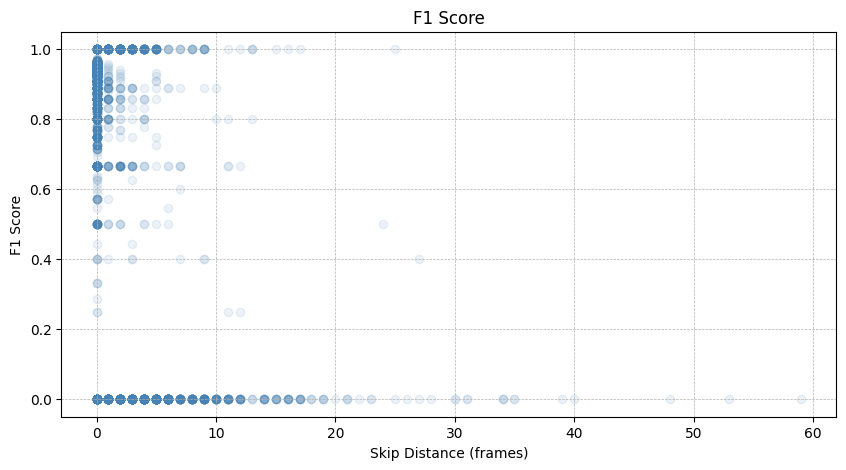

In [5]:
# x_values = sorted(skip_map.keys())[1:]  # Sorting the keys to ensure the plot is ordered
# y_values = [sum(skip_map[k]['f1']) / len(skip_map[k]['f1']) for k in x_values]

x_values = []
y_values = []
for x, s in skip_map.items():
    for f1 in s['f1']:
        x_values.append(x)
        y_values.append(f1)

# Plotting the data
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.scatter(x_values, y_values, color='steelblue', alpha=0.1)  # Create a bar plot

# Add titles and labels
plt.title('F1 Score')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('F1 Score')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

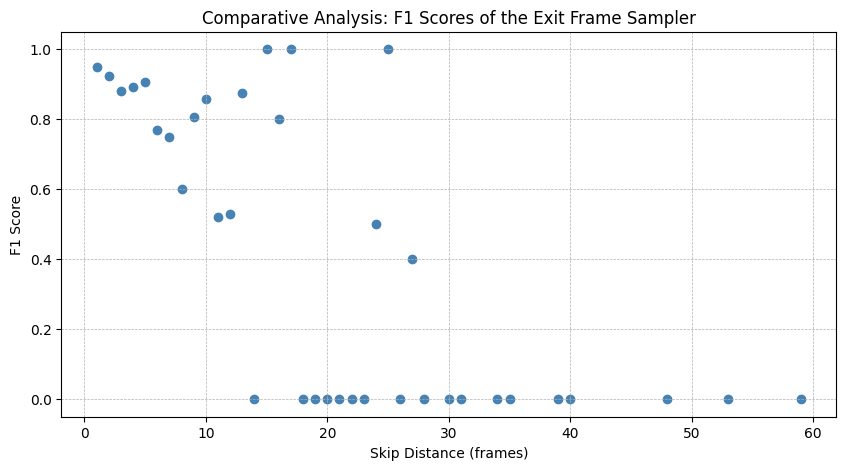

In [6]:
x_values = sorted(skip_map.keys())[1:]  # Sorting the keys to ensure the plot is ordered
y_values = [skip_map[k]['_f1'] for k in x_values]

# Plotting the data
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.scatter(x_values, y_values, color='steelblue')  # Create a bar plot

# Add titles and labels
plt.title('Comparative Analysis: F1 Scores of the Exit Frame Sampler')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('F1 Score')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

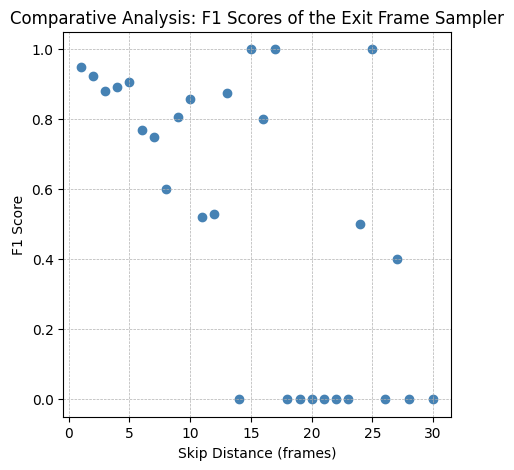

In [7]:
x_values = sorted(sk for sk in skip_map.keys() if sk <= 30)[1:]  # Sorting the keys to ensure the plot is ordered
y_values = [skip_map[k]['_f1'] for k in x_values]

# Plotting the data
plt.figure(figsize=(5, 5))  # You can adjust the figure size as needed
plt.scatter(x_values, y_values, color='steelblue')  # Create a bar plot

# Add titles and labels
plt.title('Comparative Analysis: F1 Scores of the Exit Frame Sampler')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('F1 Score')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

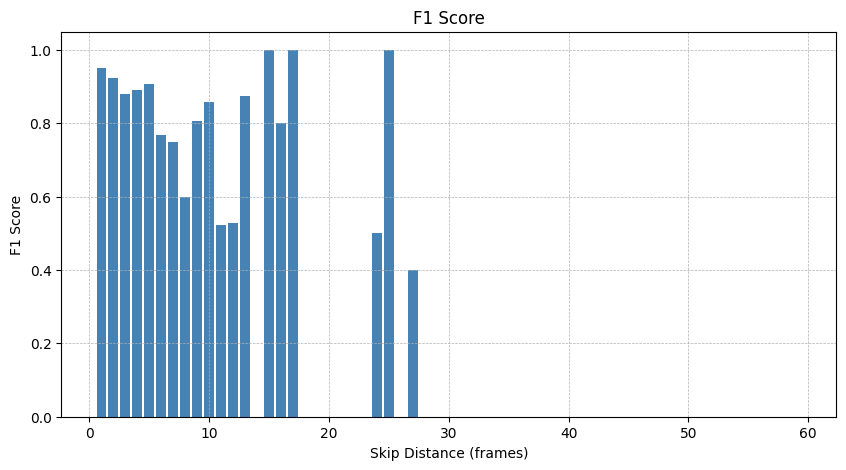

In [8]:
x_values = sorted(skip_map.keys())[1:]  # Sorting the keys to ensure the plot is ordered
y_values = [skip_map[k]['_f1'] for k in x_values]

# Plotting the data
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.bar(x_values, y_values, color='steelblue')  # Create a bar plot

# Add titles and labels
plt.title('F1 Score')
plt.xlabel('Skip Distance (frames)')
plt.ylabel('F1 Score')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

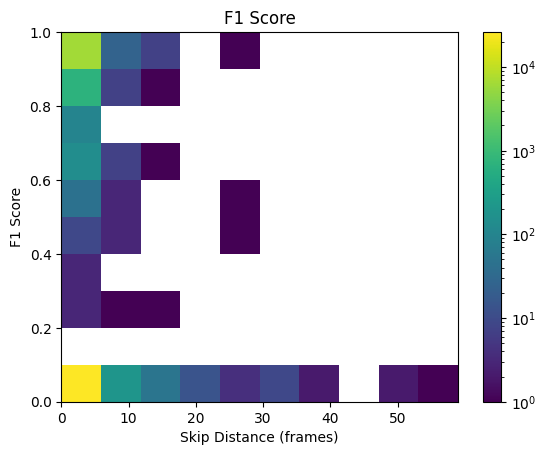

In [9]:
x_values = []
y_values = []
for x, s in skip_map.items():
    for f1 in s['f1']:
        x_values.append(x)
        y_values.append(f1)
# data = np.zeros((60, 100), dtype=int)
# for x, y in zip(x_values, y_values):
#     data[x, int(y*100)] += 1

from matplotlib.colors import LogNorm

# Plotting the data
fig, ax = plt.subplots()
# plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
h = ax.hist2d(x_values, y_values, bins=(10, 10), norm=LogNorm())  # Create a bar plot
fig.colorbar(h[3], ax=ax)

# Add titles and labels
ax.set_title('F1 Score')
ax.set_xlabel('Skip Distance (frames)')
ax.set_ylabel('F1 Score')

# Show grid lines for better readability
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

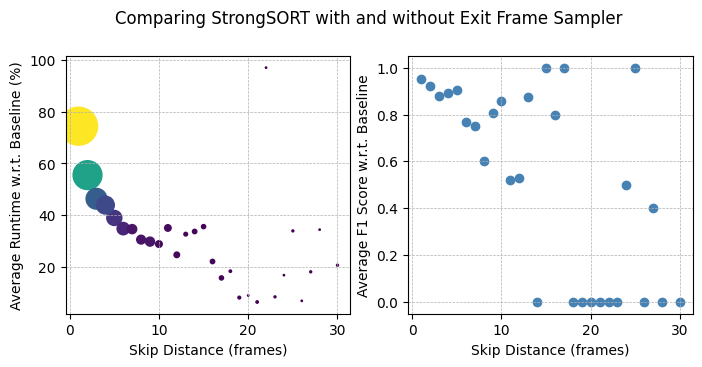

In [53]:
def plot_runtime(ax):
    # Assuming skip_map is the dictionary you have after running the above code
    # Prepare the data for plotting
    x_values = []
    y_values = []
    c_values = []
    for x, s in skip_map.items():
        if x == 0 or x > 30:
            continue
        data_points = []
        for t, d in zip(s['total_strongsort_time'], s['de_strongsort_time']):
            data_points.append(d / t)
        x_values.append(x)
        y_values.append(100 * np.average(data_points))
        c_values.append(len(data_points))

    ax.scatter(x_values, y_values, s=c_values, c=c_values)

    # Add labels
    ax.set_xlabel('Skip Distance (frames)')
    ax.set_ylabel('Average Runtime w.r.t. Baseline (%)')

    # Show grid lines for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


def plot_f1(ax):
    x_values = sorted(sk for sk in skip_map.keys() if sk <= 30)[1:]  # Sorting the keys to ensure the plot is ordered
    y_values = [skip_map[k]['_f1'] for k in x_values]

    # Plotting the data
    ax.scatter(x_values, y_values, color='steelblue')  # Create a bar plot

    # Add titles and labels
    ax.set_xlabel('Skip Distance (frames)')
    ax.set_ylabel('Average F1 Score w.r.t. Baseline')

    # Show grid lines for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
fig.suptitle('Comparing StrongSORT with and without Exit Frame Sampler')
fig.tight_layout()

plot_runtime(ax1)
plot_f1(ax2)

# Display the plot
plt.show()

In [56]:
import altair as alt
import pandas as pd

In [169]:
values = []
distance = 'Skip Distance (Frames)'
runtime = 'Average Runtime wrt Baseline (%)'
f1 = 'F1 Score wrt Baseline'
count = 'Number of skipping instance'
for x, s in skip_map.items():
    if x == 0 or x > 30:
        continue
    runtimes = []
    for t, d in zip(s['total_strongsort_time'], s['de_strongsort_time']):
        runtimes.append(d / t)

    values.append({
        distance: x,
        runtime: 100 * np.average(runtimes),
        # f1: np.average(s['f1']),
        f1: s['_f1'],
        count: len(runtimes),
    })

alt.Chart(pd.DataFrame.from_records(values)).mark_circle().encode(
    x=alt.X(distance, type='quantitative'),
    y=alt.Y(alt.repeat('column'), type='quantitative'),
    size=alt.Size(count, scale=alt.Scale(rangeMax=600)),
    color=alt.Color(count, scale=alt.Scale(scheme='viridis')),
    stroke=alt.Color(
        count,
        scale=alt.Scale(scheme='viridis'),
        legend=alt.Legend(
            values=[200, 400, 600, 746],
            title=['Number of', 'skipping', 'instances'],
        ),
    ),
    strokeOpacity=alt.OpacityValue(1),
    tooltip=[count]
).properties(
    width=170,
    height=170,
).repeat(
    column=[runtime, f1]
).properties(title='Comparing StrongSORT with vs. without (Baseline) Exit Frame Sampler')

alt.RepeatChart(...)